In [29]:
import nltk
import pandas as pd
import numpy as np
import tensorflow as tf
import string
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [30]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Swarnadwip_Sarkar\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Swarnadwip_Sarkar\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Swarnadwip_Sarkar\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package wordnet is already up-to-date!


True

In [31]:
data = pd.read_csv("IMDB Dataset.csv")

In [7]:
df = data.dropna()

In [8]:
punctuation = string.punctuation
stop_words = set(nltk.corpus.stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [9]:
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()  # remove HTML
    text = "".join([char.lower() for char in text if char not in punctuation])  # remove punctuation
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [10]:
X = df['review'].apply(clean_text).tolist()
Y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).tolist()

In [11]:
avg_words = np.mean([len(x.split()) for x in X])

In [12]:
print(f"Average number of words per review: {avg_words:.2f}")


Average number of words per review: 119.84


In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)


In [26]:
X_train_array = np.array(X_train, dtype=str)
X_test_array  = np.array(X_test, dtype=str)
Y_train_array = np.array(Y_train, dtype=np.int32)
Y_test_array  = np.array(Y_test, dtype=np.int32)

In [14]:
from tensorflow.keras.layers import TextVectorization

In [15]:
vocab_size = 20000
max_len = 200


In [16]:
vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=max_len
)

In [27]:
vectorize_layer.adapt(X_train_array)


In [50]:
vocab = np.array(vectorize_layer.get_vocabulary())
with open("vocab.txt", "w", encoding="utf-8") as f:
    for word in vocab:
        f.write(word + "\n")

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


In [34]:
model = Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, 100),
    LSTM(100),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [35]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [36]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 200, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,086,929 (7.96 MB)

 Trainable params: 2,086,929 (7.96 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

In [38]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


In [40]:
X_train_tensor = tf.constant(X_train)
X_test_tensor  = tf.constant(X_test)

# Labels as int32 tensors
Y_train_tensor = tf.constant(Y_train, dtype=tf.int32)
Y_test_tensor  = tf.constant(Y_test, dtype=tf.int32)

In [41]:
history = model.fit(
    X_train_tensor, Y_train_tensor,
    validation_data=(X_test_tensor, Y_test_tensor),
    batch_size=32,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 234s 194ms/step - accuracy: 0.5094 - loss: 0.6932 - val_accuracy: 0.5235 - val_loss: 0.6844
Epoch 2/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 229s 195ms/step - accuracy: 0.5380 - loss: 0.6711 - val_accuracy: 0.5062 - val_loss: 0.6968
Epoch 3/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 327s 279ms/step - accuracy: 0.5654 - loss: 0.6571 - val_accuracy: 0.8194 - val_loss: 0.4410
Epoch 4/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 204s 174ms/step - accuracy: 0.8674 - loss: 0.3460 - val_accuracy: 0.8775 - val_loss: 0.2953
Epoch 5/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 219s 187ms/step - accuracy: 0.9303 - loss: 0.1956 - val_accuracy: 0.8862 - val_loss: 0.2993
Epoch 6/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 230s 196ms/step - accuracy: 0.9628 - loss: 0.1158 - val_accuracy: 0.8833 - val_loss: 0.3191


In [42]:
model.save("Sentiment_Classifier_v1.keras")

In [44]:
model_without_vectorization = Sequential([
    tf.keras.Input(shape=(max_len,), dtype=tf.int32),  # input after vectorization
    model.layers[1],  # Embedding
    model.layers[2],  # LSTM
    model.layers[3],  # Dense 64
    model.layers[4],  # Dropout
    model.layers[5]   # Dense 1 sigmoid
])

In [45]:
model_without_vectorization.save(
    "Sentiment_Classifier_v1_no_vectorization.keras",
    include_optimizer=False
)

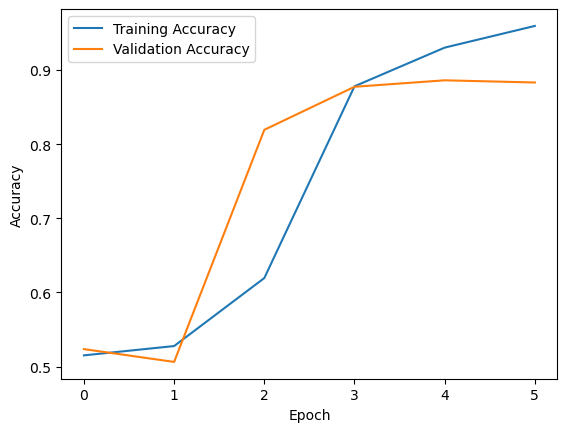

In [46]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [47]:
y_pred = model.predict(X_test_tensor)
y_pred_binary = (y_pred > 0.5).astype(int)

391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 66ms/step


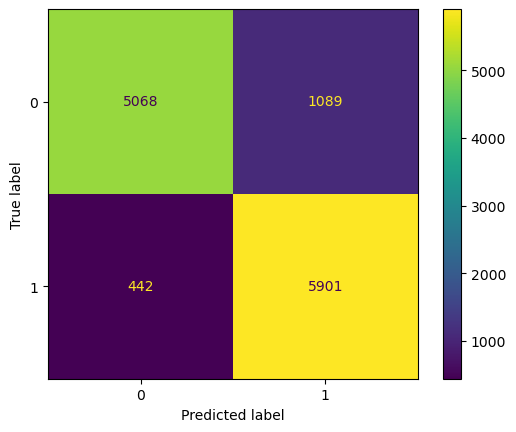

In [48]:
disp = ConfusionMatrixDisplay(confusion_matrix(Y_test_tensor, y_pred_binary))
disp.plot()

In [49]:
print(classification_report(Y_test_tensor, y_pred_binary))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87      6157
           1       0.84      0.93      0.89      6343

    accuracy                           0.88     12500
   macro avg       0.88      0.88      0.88     12500
weighted avg       0.88      0.88      0.88     12500

